# Predicting Cardiovascular Disease

# Overview

Cardiovascular disease (CVD) is the leading global cause of death. Analyzing a dataset of 70,000 surveyed patients, we aimed to identify correlations and predictors of CVD. Through data cleaning and analysis, we discovered significant factors that influence the likelihood of having CVD. Specifically, we found that systolic and diastolic blood pressure, cholesterol, age, and weight were the largest indicators of susceptibility to CVD.

# Names

- Andrew Tan
- Arnav Taneja
- Matthew Kim
- Henry Liu

<a id='research_question'></a>
# Research Question

What (if any) effect do age, height, weight, gender, systolic blood pressure, diastolic blood pressure, cholesterol levels, glucose levels, smoking activity, alcoholism, and physical activity determine whether or not an individual gets CVD?  How well can we predict whether a person will have CVD given their age, height, weight, gender, systolic blood pressure, diastolic blood pressure, cholesterol levels, glucose levels, smoking activity, alcoholism, and physical activity? 

<a id='background'></a>

## Background & Prior Work

Cardiovascular disease is the leading global cause of death, resulting in over 19 million deaths in 2020 [2]. CVD is a multifactorial disease with several risk factors, such as age, gender, high blood pressure, and obesity. Therefore, it is essential to understand the interactions among these risk factors to develop effective prevention and treatment strategies. In particular, exploring how age, height, weight, gender, systolic blood pressure (SBP), and diastolic blood pressure (DBP) interact can help identify the risk of CVD.


Numerous studies have shown that age, gender, and blood pressure are significant predictors of CVD risk. For instance, a study conducted in Italy found a strong correlation between levels of SBP and the risk of coronary heart disease and cerebrovascular disease [3]. Additionally, a study conducted in the southern states of the US identified obesity, as measured by body mass index (BMI), as a significant risk factor for CVD [1].


While previous research has identified the importance of these risk factors, there is still much to learn about how these factors interact to predict CVD development. For example, the Framingham study has been investigating the predictive ability of various risk factors, including age, gender, BMI, and blood pressure, for CVD in Framingham, Massachusetts, since 1948. This study found that combining multiple risk factors enhances the predictive accuracy of CVD risk compared to using a single risk factor [4].


In summary, understanding the complex interactions among physiological factors that contribute to CVD risk is crucial for developing effective prevention and treatment strategies. Although age, gender, blood pressure, and obesity have been identified as critical risk factors, further research is needed to investigate how these factors interact and how well they can predict CVD risk.



References:
<br>[1] Akil, Luma, and H Anwar Ahmad. "Relationships between obesity and cardiovascular diseases in four southern states and Colorado." Journal of health care for the poor and underserved vol. 22,4 Suppl (2011)
<br>[2] American Heart Association. "Heart Disease and Stroke Statistics-2022 Update: A Report From the American Heart Association." Circulation, vol. 145, no. 8, 2022
<br>[3] Borghi, Claudio et al. "The relationship between systolic blood pressure and cardiovascular risk--results of the Brisighella Heart Study." Journal of clinical hypertension (Greenwich, Conn.) vol. 5,1 (2003)
<br>[4] D'Agostino, Ralph B Sr et al. "Cardiovascular Disease Risk Assessment: Insights from Framingham." Global heart vol. 8,1 (2013)

# Hypothesis


  Our team hypothesizes that systolic and diastolic blood pressure will be the most important factors in determining whether or not one has cardiovascular disease. Additionally, we suspect that age, height, weight, and gender will also be important since they can be used to compute one's obesity, which, as highlighted in the background and prior work section, is a common factor amongst those with cardiovascular disease. Additionally, because we hypothesize that these factors are effective in predicting one’s likelihood of getting cardiovascular disease, we also hypothesize that we will be able to create a model that accurately predicts whether a person will have cardiovascular disease based on their health data. We acknowledge that predicting one’s likelihood is not limited only to the factors we are examining, but we believe that our selected factors are sufficient to produce an accurate prediction.

# Dataset(s)

- Dataset Name: Cardiovascular Disease Dataset
- Link to the dataset: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset 
- Number of observations: 70,000

The Cardiovascular Disease Dataset contains values that were collected at the moment of medical examination from a random sample of 70,000 patients. Variables that were recorded include age, height, weight, gender, systolic blood pressure, cholesterol, glucose, smoking, alcohol intake, physical activity, and the presence or absence of CVD. Patients containing erroneous data, missing data values, heights, weights, and blood pressures that are significant outliers or impossible to measure will be removed.

# Setup

In [1080]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay

In [1081]:
cardio = pd.read_csv('./cardio_train.csv', sep=';')
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Data Cleaning & Pre-Processing

In [1082]:
def featureConversion(item):
    if item == 1:
        return 'normal'
    elif item == 2:
        return 'above normal'
    else:
        return 'well above normal'

# Converting data from days to years
cardio['age'] = cardio['age'] / 365
    
# Filtering out improbable data
cardio = cardio[(cardio['ap_hi'] > 0 & (cardio['ap_lo'] > 0))]
cardio = cardio[(cardio['age'] >= cardio['age'].quantile(0.05)) & (cardio['age'] <= cardio['age'].quantile(0.95)) &
                 (cardio['height'] >= cardio['height'].quantile(0.05)) & (cardio['height'] <= cardio['height'].quantile(0.95))]

cardio2 = cardio.copy()

# Converting variables from numbered categories to detailed categories
cardio['cholesterol'] = cardio['cholesterol'].apply(featureConversion)
cardio['gluc'] = cardio['gluc'].apply(featureConversion)
cardio['gender'] = cardio['gender'].apply(lambda x: 'woman' if x == 1 else 'man')
cardio['smoke'] = cardio['smoke'].apply(lambda x: 'non-smoker' if x == 0 else 'smoker')
cardio['alco'] = cardio['alco'].apply(lambda x: 'no alcohol' if x == 0 else 'alcohol')
cardio['active'] = cardio['active'].apply(lambda x: 'no exercise' if x == 0 else 'exercise')
cardio['cardio'] = cardio['cardio'].apply(lambda x: 'no CVD' if x == 0 else 'has CVD')
cardio2

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,57.736986,1,165,80.0,150,80,1,1,0,0,1,1
69995,99993,52.712329,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61.920548,1,158,126.0,140,90,2,2,0,0,1,1
69998,99998,61.454795,1,163,72.0,135,80,1,2,0,0,0,1


# Data Visualization

In [1083]:
summary_stats = cardio.describe()
print(summary_stats)

                 id           age        height        weight         ap_hi  \
count  57699.000000  57699.000000  57699.000000  57699.000000  57699.000000   
mean   50007.318134     53.452821    164.465398     74.130570    128.940103   
std    28828.062626      5.851340      6.360786     13.914066    158.812818   
min        0.000000     41.284932    152.000000     10.000000      1.000000   
25%    25066.500000     49.616438    160.000000     65.000000    120.000000   
50%    50150.000000     53.964384    165.000000     72.000000    120.000000   
75%    74855.000000     58.087671    169.000000     82.000000    140.000000   
max    99999.000000     63.720548    178.000000    181.000000  16020.000000   

              ap_lo  
count  57699.000000  
mean      96.187820  
std      183.228062  
min      -70.000000  
25%       80.000000  
50%       80.000000  
75%       90.000000  
max    11000.000000  


The dataset consists of 69,960 observations on various factors related to CVD. The mean age of the individuals is approximately 53 years, with a standard deviation of 6.76 years. The majority of the participants are male (1.35 on average), and the average height and weight are around 164 cm and 74 kg, respectively.

The blood pressure measurements, represented by ap_hi and ap_lo, have a wide range of values. The average systolic blood pressure (ap_hi) is 128.85, while the average diastolic blood pressure (ap_lo) is 96.64. Both measurements have relatively high standard deviations, indicating significant variability in the data.


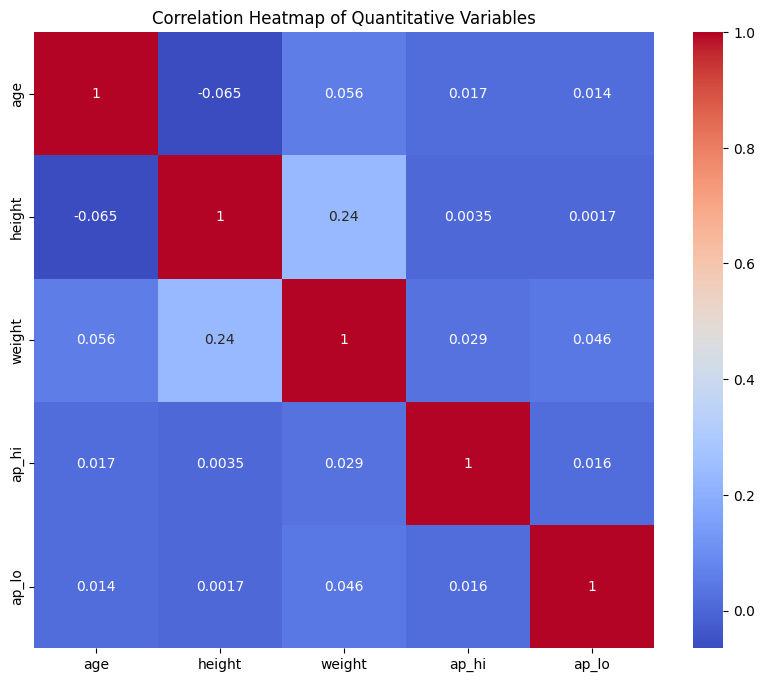

In [1084]:
# Select quantitative variables
quantitative_vars = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Calculate the correlation matrix
corr_matrix = cardio[quantitative_vars].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Quantitative Variables')
plt.show()

This heat map visually describes the relationship between the quantitative variables in our study. None of the variables are strongly correlated.


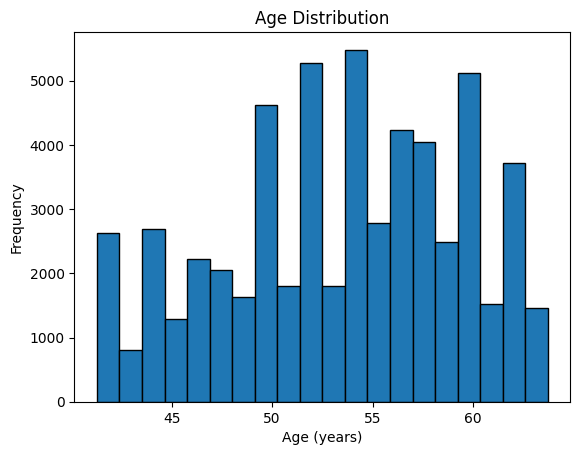

In [1085]:
# Visualizing Age Distribution
plt.hist(cardio['age'], bins=20, edgecolor='k')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

Age is normally distributed with a mean age is around 50.

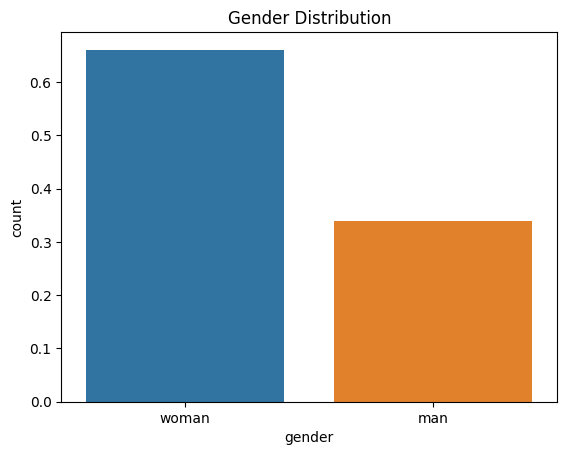

In [1086]:
# Visualizing Gender Distribution
gender_counts = cardio['gender'].value_counts() / cardio['gender'].value_counts().sum()
sns.barplot(x=gender_counts.index, y=gender_counts)
plt.title('Gender Distribution')
plt.show()

There’s a higher proportion of women present in the dataset than men.


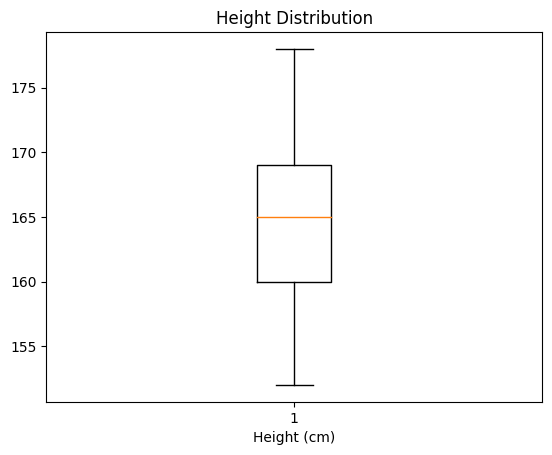

In [1087]:
# Visualizing Height Distribution
plt.boxplot(cardio['height'])
plt.xlabel('Height (cm)')
plt.title('Height Distribution')
plt.show()

The median height of the data set is around 165 cm.

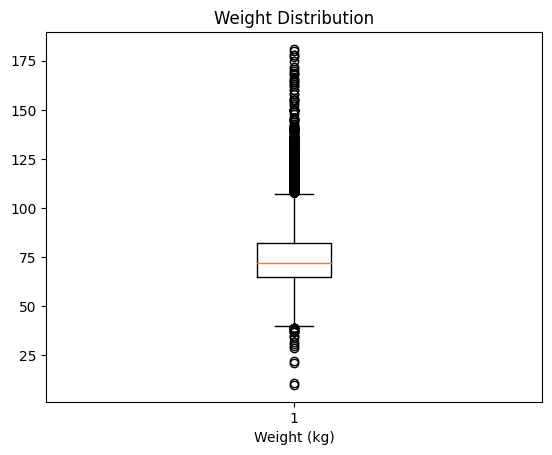

In [1088]:
# Visualizing Weight Distribution
plt.boxplot(cardio['weight'])
plt.xlabel('Weight (kg)')
plt.title('Weight Distribution')
plt.show()

The median weight distribution is 72 kg.

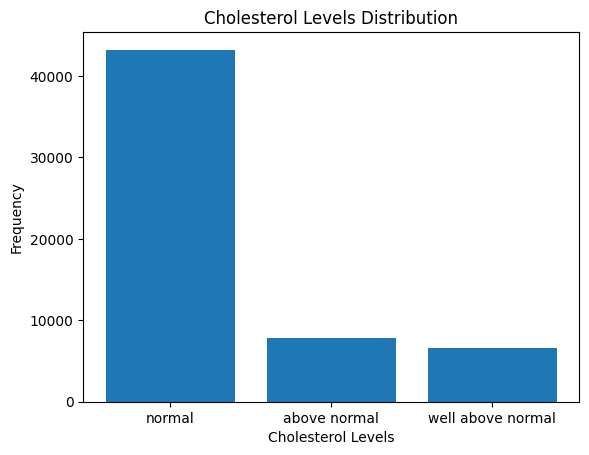

In [1089]:
# Visualizing Cholesterol Levels
cholesterol_counts = cardio['cholesterol'].value_counts()
plt.bar(cholesterol_counts.index, cholesterol_counts)
plt.xlabel('Cholesterol Levels')
plt.ylabel('Frequency')
plt.title('Cholesterol Levels Distribution')
plt.show()

The majority of the patients sampled in our data set have normal cholesterol levels.

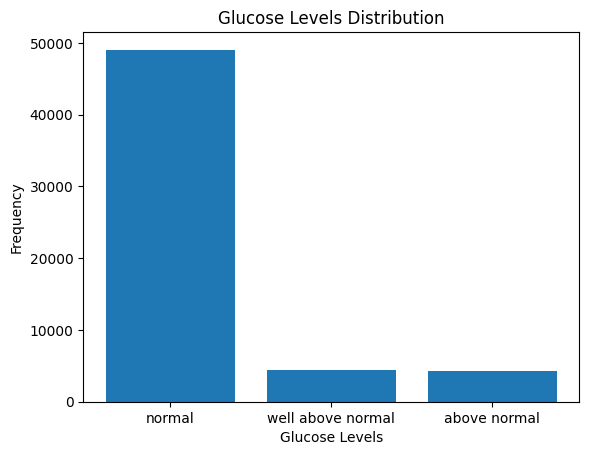

In [1090]:
# Visualizing Glucose Levels
glucose_counts = cardio['gluc'].value_counts()
plt.bar(glucose_counts.index, glucose_counts)
plt.xlabel('Glucose Levels')
plt.ylabel('Frequency')
plt.title('Glucose Levels Distribution')
plt.show()

The majority of the patients sampled in our data set have normal glucose levels.

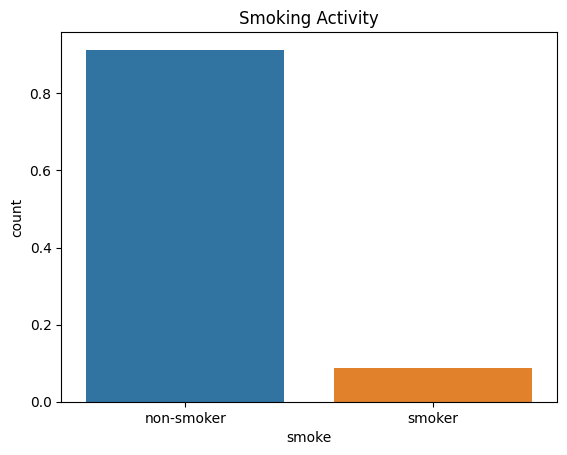

In [1091]:
# Visualizing Smoking Activity
smoke_counts = cardio['smoke'].value_counts() / cardio['smoke'].value_counts().sum()
sns.barplot(x=smoke_counts.index, y=smoke_counts)
plt.title('Smoking Activity')
plt.show()

The majority of the patients sampled in our data set do not smoke.

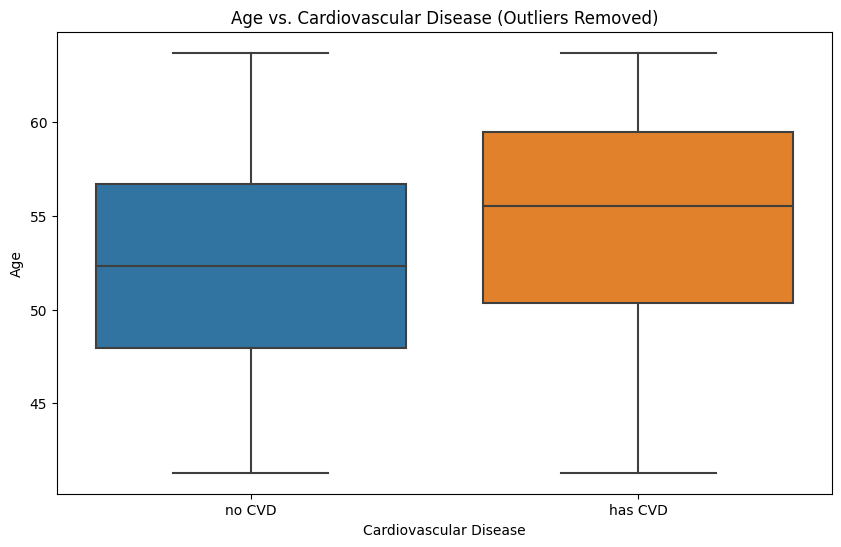

In [1092]:
# Create box plots for age vs. cardiovascular disease
plt.figure(figsize=(10, 6))
sns.boxplot(data=cardio, x='cardio', y='age')
plt.xlabel('Cardiovascular Disease')
plt.ylabel('Age')
plt.title('Age vs. Cardiovascular Disease (Outliers Removed)')
plt.show()

People of higher ages have a higher tendency to have CVD. The median, Q1, and Q3 for age are all higher for those with CVD than those without CVD. 

Text(0.5, 1.0, 'BMI vs. Cardiovascular Disease (Outliers Removed)')

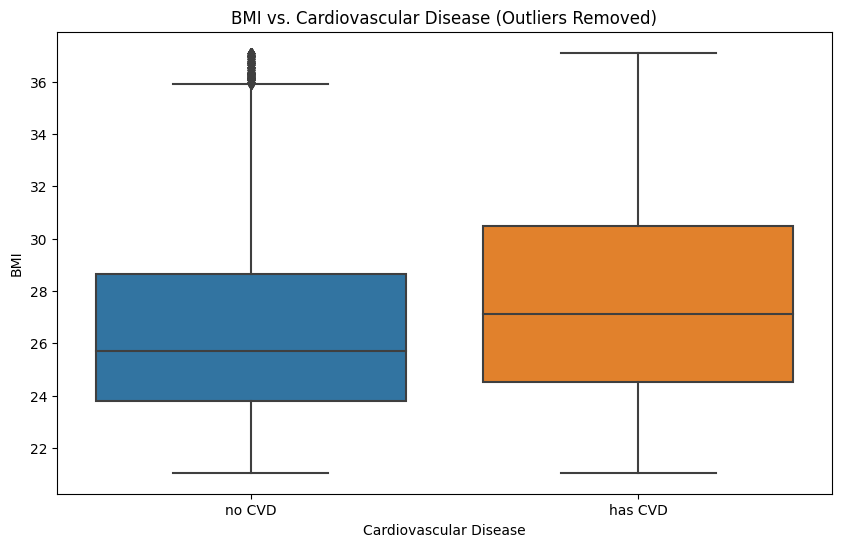

In [1093]:
# Calculate BMI (Body Mass Index)
cardio['bmi'] = cardio['weight'] / ((cardio['height'] / 100) ** 2)

# Filter out outliers in BMI
cardio_filtered = cardio[(cardio['bmi'] >= cardio['bmi'].quantile(0.05)) & (cardio['bmi'] <= cardio['bmi'].quantile(0.95))]

# Add filtered BMI to cardio2
cardio2['bmi'] = cardio_filtered['bmi']

# Remove rows with NaN values in cardio2
cardio2 = cardio2.dropna()

# Reorder the columns
cols = list(cardio2.columns)
cols.remove('bmi')
cols.insert(-1, 'bmi')
cardio2 = cardio2[cols]

# Create a box plot for BMI vs. cardiovascular disease
plt.figure(figsize=(10, 6))
sns.boxplot(data=cardio_filtered, x='cardio', y='bmi')
plt.xlabel('Cardiovascular Disease')
plt.ylabel('BMI')
plt.title('BMI vs. Cardiovascular Disease (Outliers Removed)')

We observe that people with higher BMIs indicate a higher tendency to have cardiovascular disease. The median, Q1, and Q3 for BMI are higher for those with cardiovascular disease than those without cardiovascular disease.

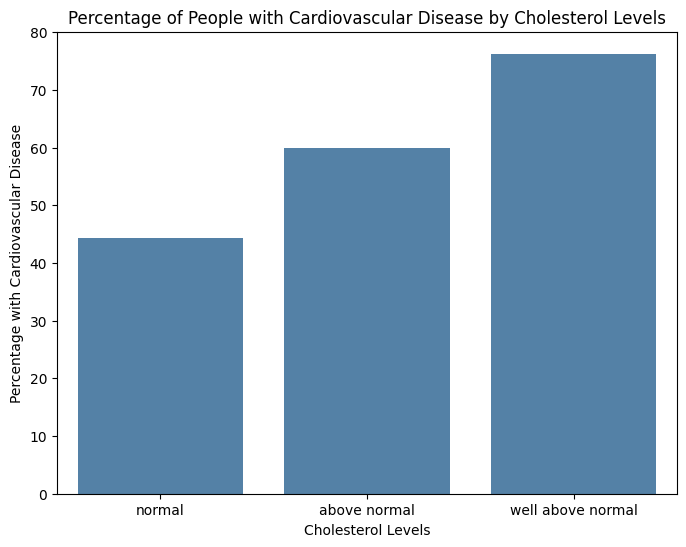

In [1094]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage =cardio.groupby(['cholesterol', 'cardio']).size().unstack() /cardio.groupby('cholesterol').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='cholesterol', y='has CVD', color='steelblue',
            order=['normal', 'above normal', 'well above normal'])  # Specify the desired order of the bars
plt.xlabel('Cholesterol Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Cholesterol Levels')

plt.show()


Sampled patients who have higher cholesterol levels have a higher likelihood of having cardiovascular disease.

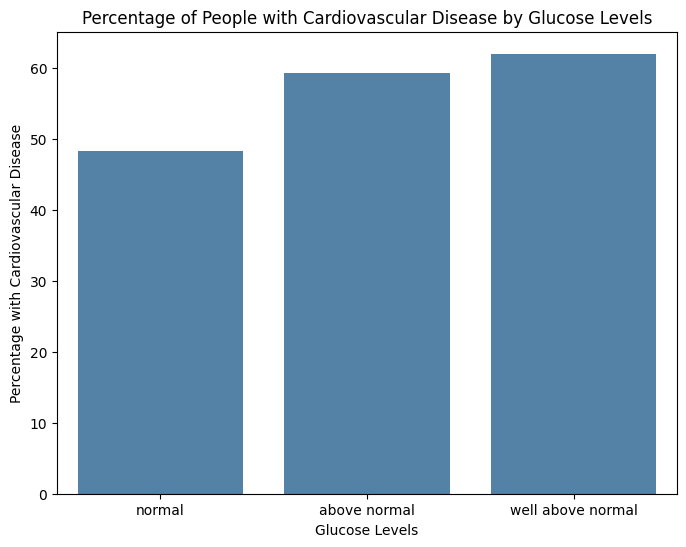

In [1095]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['gluc', 'cardio']).size().unstack() /cardio.groupby('gluc').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='gluc', y='has CVD', color='steelblue',
            order=['normal', 'above normal', 'well above normal'])  # Specify the desired order of the bars
plt.xlabel('Glucose Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Glucose Levels')

plt.show()

Sampled patients who have higher glucose levels have a higher likelihood of having cardiovascular disease.

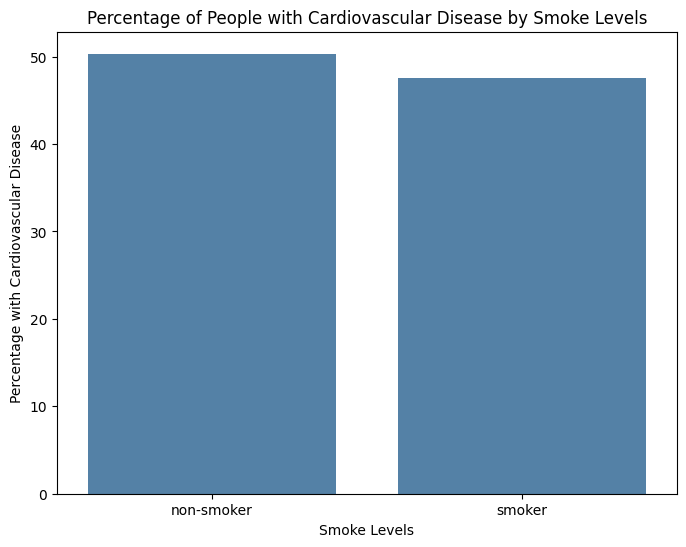

In [1096]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['smoke', 'cardio']).size().unstack() / cardio.groupby('smoke').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='smoke', y='has CVD', color='steelblue')
plt.xlabel('Smoke Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Smoke Levels')
plt.show()

We observe that there is little difference between the percentage of those who smoke and those who don’t and whether they have cardiovascular disease. 

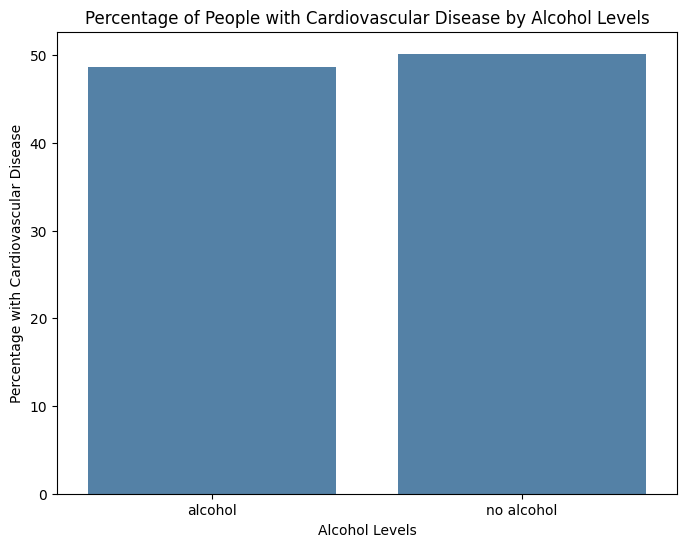

In [1097]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['alco', 'cardio']).size().unstack() / cardio.groupby('alco').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='alco', y='has CVD', color='steelblue')
plt.xlabel('Alcohol Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Alcohol Levels')


plt.show()

We observe that there is little difference between the percentage of those who intake alcohol and those who don’t and whether they have cardiovascular disease. 

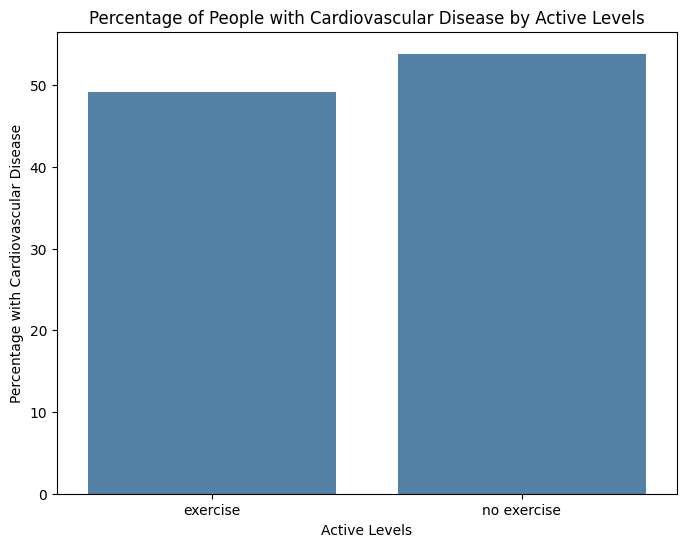

In [1098]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['active', 'cardio']).size().unstack() / cardio.groupby('active').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='active', y='has CVD', color='steelblue')
plt.xlabel('Active Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Active Levels')
plt.show()

We observe that those who are active are less likely to develop/be diagnosed with cardiovascular disease (CVD). 

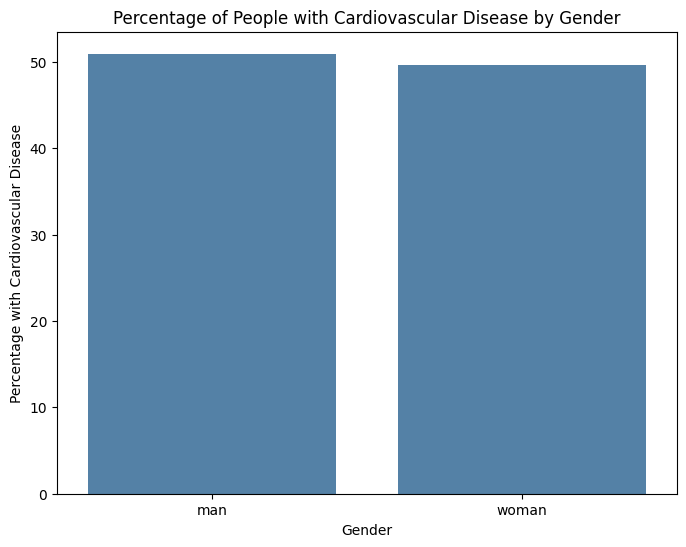

In [1099]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['gender', 'cardio']).size().unstack() / cardio.groupby('gender').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='gender', y='has CVD', color='steelblue')
plt.xlabel('Gender')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Gender')
plt.show()

We observe that there is little difference between the percentage of male and females sampled and whether they have cardiovascular disease. 

# Data Analysis & Results

In [1100]:
# Transforming columns
numeric_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
preproc = ColumnTransformer(
    transformers = [
        ('standard_scaler', StandardScaler(), numeric_cols),
        ('categorical_cols', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Getting feature and response columns
dataset = cardio2[numeric_cols + cat_cols]
result = cardio2['cardio']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset,
                                                   result,
                                                   test_size=0.2,
                                                   random_state=1)

In [1101]:
# Decision Tree
# Making pipeline and fitting it on training set
pl_dt = Pipeline([
    ('preprocessor', preproc),
    ('dt', DecisionTreeClassifier(max_depth=5)),
])
pl_dt.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_dt = pl_dt.predict(X_train)
testing_prediction_dt = pl_dt.predict(X_test)
training_accuracy_dt = metrics.accuracy_score(training_prediction_dt, y_train)
testing_accuracy_dt = metrics.accuracy_score(testing_prediction_dt, y_test)
print(f'Training accuracy: {training_accuracy_dt}')
print(f'Testing accuracy: {testing_accuracy_dt}')

Training accuracy: 0.7254114137234144
Testing accuracy: 0.7235373364126251


The decision tree model achieved a testing accuracy of 72.35%, indicating its moderate predictive performance in identifying heart diseases. This model works by recursively partitioning the dataset based on feature thresholds, creating a hierarchical structure of if-else decision rules. It selects the most informative features at each step to maximize the separation between classes, allowing for interpretable and understandable decision-making in the prediction of heart diseases.

In [1102]:
# Logistic Regression
# Making pipeline and fitting it on training set
pl_lr = Pipeline([
    ('preprocessor', preproc),
    ('lr', LogisticRegression()),
])
pl_lr.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_lr = pl_lr.predict(X_train)
testing_prediction_lr = pl_lr.predict(X_test)
training_accuracy_lr = metrics.accuracy_score(training_prediction_lr, y_train)
testing_accuracy_lr = metrics.accuracy_score(testing_prediction_lr, y_test)
print(f'Training accuracy: {training_accuracy_lr}')
print(f'Testing accuracy: {testing_accuracy_lr}')

Training accuracy: 0.7192522375132326
Testing accuracy: 0.7120862201693611


The logistic regression model achieved a testing accuracy of 71.20%, indicating its moderate predictive performance in identifying heart diseases. A logistic regression model is employed to predict the likelihood of CVD based on given features. By using a mathematical function to transform the input features into a probability score, the model enables straightforward classification and interpretation of the probability of an individual having CVD.

**TO BE ADDED - SUPPORT VECTOR MACHINE MODEL**

**TO BE ADDED - GAUSSIAN NAIVE BAYES MODEL**

**TO BE ADDED - LIGHTGBM MODEL**

**TO BE ADDED - XGBOOST MODEL**

**TO BE ADDED - RANDOM FOREST MODEL**

Accuracy Score: 0.7235373364126251
Precision Score: 0.7829818538499265
Recall Score: 0.6162902914495271
F1 Score: 0.6897073118047304


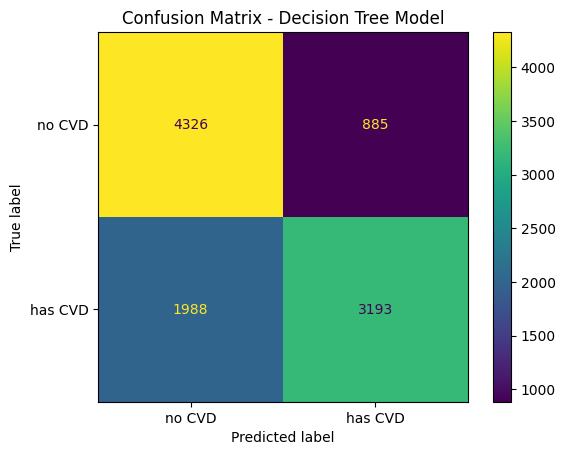

In [1103]:
# Confusion Matrix for Decision Tree Model
display_labels = ['no CVD', 'has CVD']
dt_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_dt, X_test, y_test, display_labels=display_labels)

dt_accuracy = accuracy_score(y_test, testing_prediction_dt)
dt_precision = precision_score(y_test, testing_prediction_dt, pos_label=1)
dt_recall = recall_score(y_test, testing_prediction_dt, pos_label=1)
dt_f1 = f1_score(y_test, testing_prediction_dt, pos_label=1)
dt_confusion_matrix.ax_.set_title('Confusion Matrix - Decision Tree Model')

print(f'Accuracy Score: {dt_accuracy}')
print(f'Precision Score: {dt_precision}')
print(f'Recall Score: {dt_recall}')
print(f'F1 Score: {dt_f1}')

dt_confusion_matrix

Accuracy Score: 0.7120862201693611
Precision Score: 0.7400745777582803
Recall Score: 0.6512256321173518
F1 Score: 0.6928131416837783


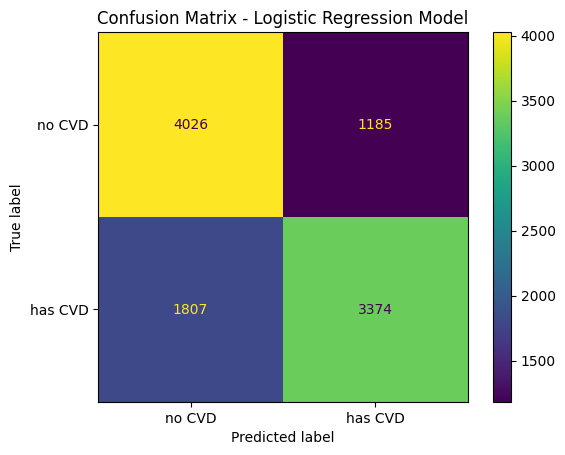

In [1104]:
# Confusion matrix for Logistic Regression Model
display_labels = ['no CVD', 'has CVD']
lr_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_lr, X_test, y_test, display_labels=display_labels)

lr_accuracy = accuracy_score(y_test, testing_prediction_lr)
lr_precision = precision_score(y_test, testing_prediction_lr, pos_label=1)
lr_recall = recall_score(y_test, testing_prediction_lr, pos_label=1)
lr_f1 = f1_score(y_test, testing_prediction_lr, pos_label=1)
lr_confusion_matrix.ax_.set_title('Confusion Matrix - Logistic Regression Model')

print(f'Accuracy Score: {lr_accuracy}')
print(f'Precision Score: {lr_precision}')
print(f'Recall Score: {lr_recall}')
print(f'F1 Score: {lr_f1}')

lr_confusion_matrix

**NEEDS TO BE UPDATED**

Overall, when we compare the models purely by their accuracy score, there is only a difference of around 2%. However, the decision tree model has a higher precision score than the logistic regression model by around 4%. This signifies that the decision tree has fewer false positives. On the other hand, the decision tree model has a lower recall score by around 3%. This indicates that it has more false negatives. In the context of predicting cardiovascular disease, we could argue that having more false negatives is bad. This is because if we are predicting the presence of a disease, it is arguably more harmful to say someone does not have it when they do, rather than saying that someone has it when they don't. However, both cases can be argued.

For this reason, though, we would venture towards saying that the logistic regression model has better predictions regarding whether or not someone has cardiovascular disease because of the higher recall score. However, if we prioritize having fewer false positives (higher precision) and higher accuracy, one could argue that the decision tree model had better predictions.

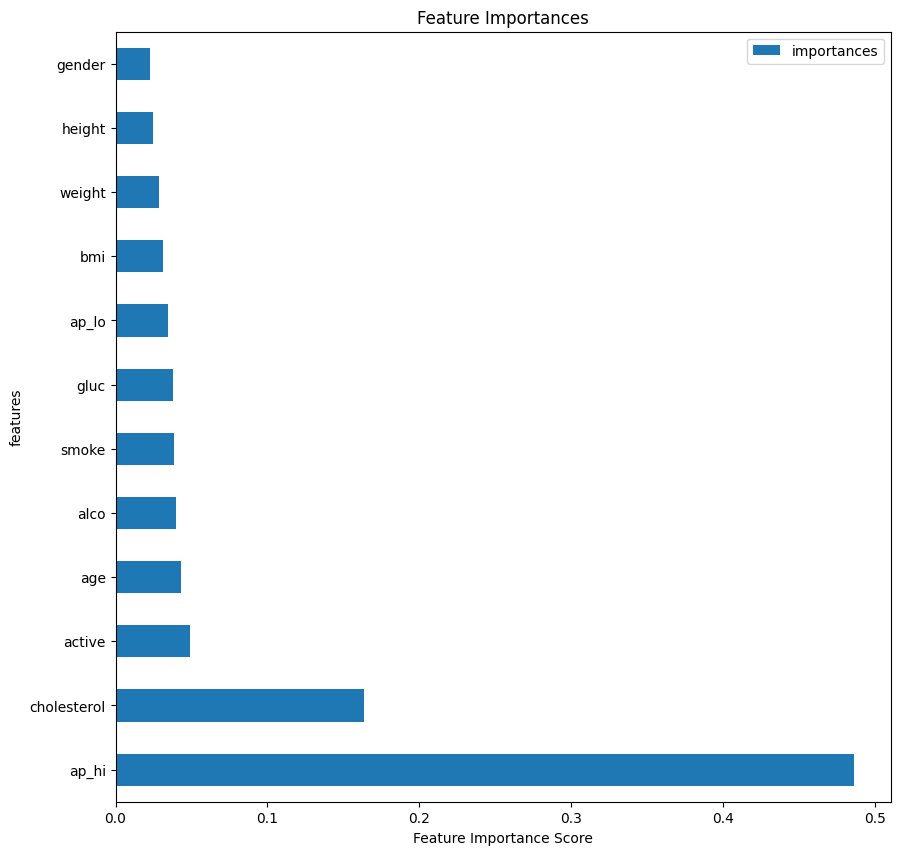

In [1105]:
# Feature importances
ss = StandardScaler()
X_train[numeric_cols] = ss.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = ss.transform(X_test[numeric_cols])
my_model=xgb.XGBClassifier(n_estimators=100).fit(X_train,y_train)
feat_imp=pd.DataFrame({'importances':my_model.feature_importances_})
feat_imp['features']=X_train.columns
feat_imp=feat_imp.sort_values(by='importances',ascending=False)
feat_imp=feat_imp.set_index('features')
feat_imp.plot.barh(title='Feature Importances',figsize=(10,10))
plt.xlabel('Feature Importance Score')
plt.show()

XGBoost's feature importance algorithm calculates the importance of each feature in predicting the target variable (CVD). It retrieves scores for attributes in boosted decision trees, which organize data into a tree-like structure. Boosting combines weak learners (decision trees) iteratively to create a strong learner, correcting errors made by previous trees. The algorithm learns by fitting residuals from preceding trees. XGBoost's feature importance assesses how frequently features are used in important decisions within boosted trees. Crucial features for accurate predictions receive higher importance scores. These scores are explicitly calculated for each attribute, enabling ranking and comparison. According to the feature importance plot, ap_hi (systolic blood pressure) and cholesterol have the highest feature importance scores and the largest effect on predicting one's likelihood of having CVD.  

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


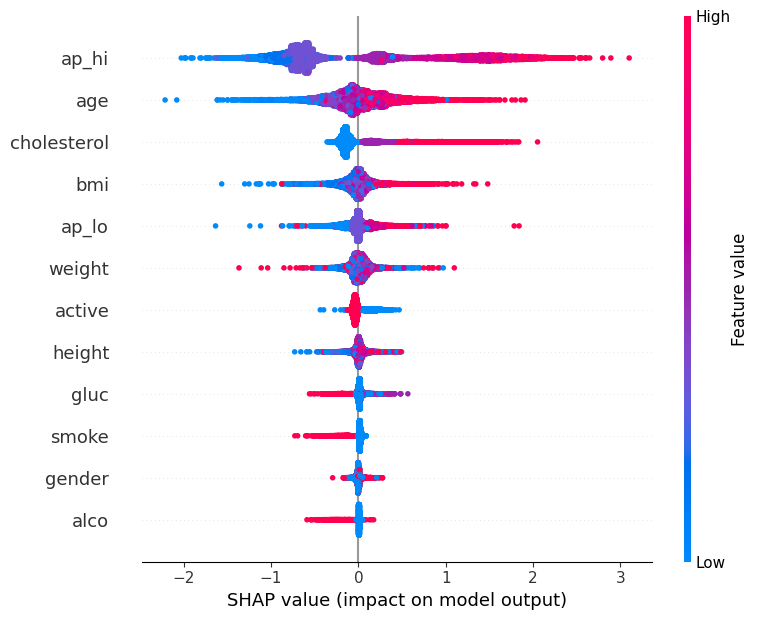

In [1106]:
# SHAP plot
explainer=shap.TreeExplainer(my_model)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test)

A SHAP plot visualizes the contribution of individual features to a machine learning model's predictions. It examines each feature's impact on the model output while taking into account their interactions with other features, providing insights into their relative importance.

The SHAP plot provides valuable insights into the relationship between various features and the prediction of CVD. Notably, as the feature values of systolic and diastolic blood pressure, cholesterol, weight, BMI, and age increase, their corresponding SHAP values also increase. This observation suggests that these factors play a significant role in determining the likelihood of developing CVD. Furthermore, the consistent alignment of these findings with existing studies further strengthens the reliability of the model and highlights the importance of monitoring and managing blood pressure as a major risk factor for CVD in the aging population.

# Ethics & Privacy

One of the ethical concerns revolves around the potential inaccuracies in the recording of measurements by individuals. The limitations in our dataset, stemming from these potential inaccuracies, may restrict the accuracy and holistic understanding of the factors involved. However, since we lack additional information, we must assume that our analysis is conducted ethically, taking into account the limitations of the data. Our questions are designed to focus on indisputable characteristics of the human body, combined with the statistical data available, in order to mitigate inherent human biases.

It is worth noting that human intervention during data collection may have introduced potential inaccuracies, although the large dataset helps to minimize such errors. Additionally, the data we utilized comes from a reliable and publicly accessible source, Kaggle, which implies that it was obtained legally and through scientific means. Although direct transparency regarding the data collection process is not explicitly stated, the professional setting of medical examinations and the involvement of medical professionals should alleviate concerns.
The credibility of the main data scientist, Svetlana Ulianova, who was responsible for collecting the dataset, adds to the reliability of the data. With a Master's degree from New York University and experience as a data scientist at reputable companies like Mastercard, her qualifications suggest unbiased and accurate data collection methods.

Given the gravity of CVD, it is crucial that our analysis be conducted methodically and without external bias, as we aim to develop a tool that can help predict its presence in a professional setting.

Moving forward, to mitigate bias and minimize user error, we can enhance data accuracy and ensure a more representative sample by restricting data entry to trained professionals proficient in accurate data recording.

# Conclusion & Discussion

Our initial hypothesis was validated as we found that systolic blood pressure played a significant role, consistent with our expectations. Additionally, our analysis highlighted the significance of diastolic blood pressure, along with cholesterol, age, weight and BMI, as indicated by the SHAP plot.

**NEEDS TO BE UPDATED**

For constructing our predictive models, we employed Logistic Regression and Decision Tree approaches. Although the accuracy scores of these models showed only a marginal difference of approximately 2%, the Decision Tree model demonstrated higher precision but lower recall. The choice between these models depends on the desired trade-off between false positives and false negatives.

Nevertheless, it is important to acknowledge that our models have limitations and are not 100% accurate. However, they provide a valuable foundation for further improvements. To enhance the accuracy, we can explore additional binary classification algorithms and fine-tune their hyperparameters. Moreover, acquiring a larger and more diverse dataset would contribute to refining our model's performance.

The significance of this study lies in identifying crucial factors, such as systolic blood pressure, weight, age, and others, for predicting the presence of CVD. This information enables individuals to recognize potential risks associated with extreme values of these factors. Furthermore, we have successfully developed a reasonably accurate model for predicting the presence of CVD based on individual specifications.

Given the importance of CVD and the potential consequences of mispredictions, efforts to improve the model's accuracy (currently 71.6%) and incorporate more comprehensive data should be pursued.

## Interface

**TO BE ADDED**